In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import ruptures as rpt
from statsmodels.tsa.stattools import adfuller

In [3]:
# Set visualization style
sns.set(style="whitegrid")

In [4]:
# Load the dataset (replace 'your_file_path.csv' with the actual file path)
file_path=r'C:\Users\HP\week 10\Statistical-modeling-of-timeseries-data\data\Copy of BrentOilPrices.csv'
data = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_1100\2463648256.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)


In [5]:
# Display the first few rows to understand the data
print(data.head())

        Date  Price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63


In [6]:
# Step 1: Data Preprocessing
# Ensure the data is sorted by date
data = data.sort_values('Date').reset_index(drop=True)

In [7]:
# Check for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 Date     0
Price    0
dtype: int64


In [8]:
# Fill or interpolate missing prices, if any
data['Price'] = data['Price'].interpolate(method='linear')

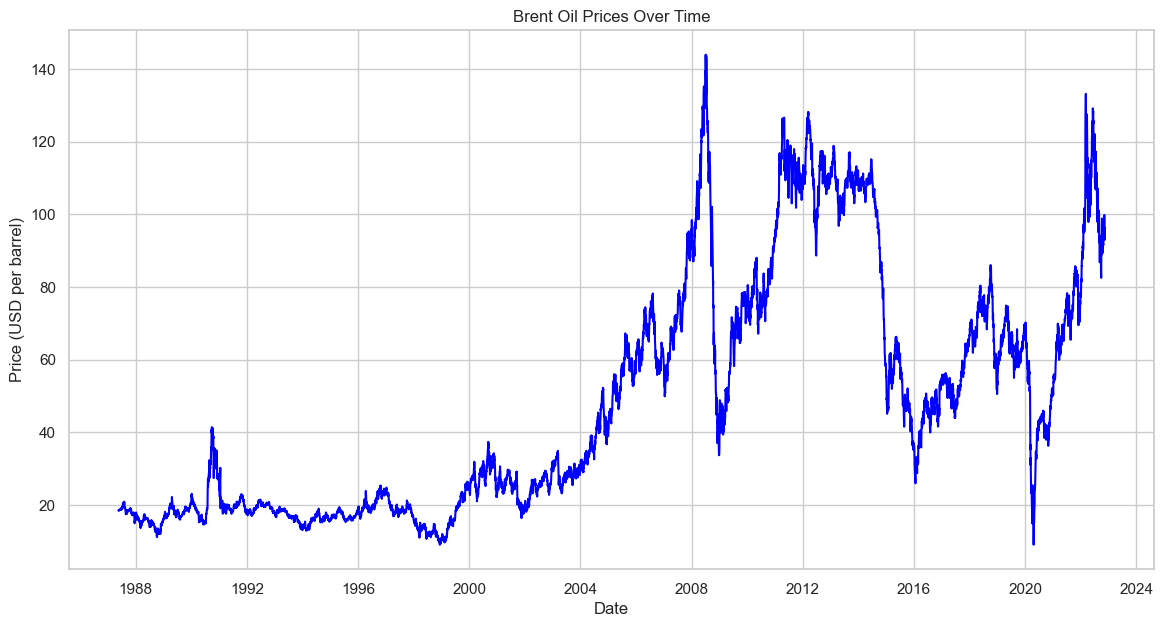

In [9]:
# Step 2: Exploratory Data Analysis (EDA)
# Plot the time series of Brent oil prices
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Price'], color='blue')
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD per barrel)")
plt.show()

In [10]:
# Descriptive statistics
print("Descriptive Statistics:\n", data['Price'].describe())

Descriptive Statistics:
 count    9011.000000
mean       48.420782
std        32.860110
min         9.100000
25%        19.050000
50%        38.570000
75%        70.090000
max       143.950000
Name: Price, dtype: float64


In [11]:
# Step 3: Change Point Detection using Ruptures Library
# Change point detection - using Pelt algorithm with a penalty value
algo = rpt.Pelt(model="rbf").fit(data['Price'].values)
result = algo.predict(pen=10)  # Adjust the penalty value to control sensitivity


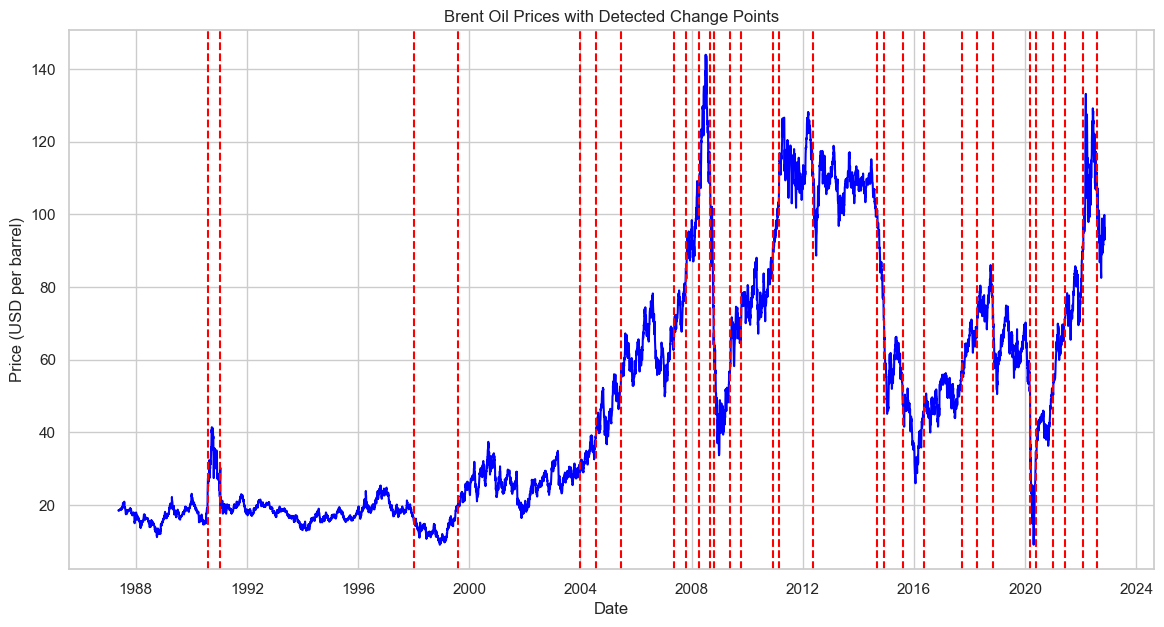

In [12]:
# Plot the detected change points
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Price'], color='blue')

# Ensure change points are within data bounds
for cp in result:
    if cp < len(data):  # Check if index is within bounds
        plt.axvline(data['Date'].iloc[cp], color='red', linestyle='--')

plt.title("Brent Oil Prices with Detected Change Points")
plt.xlabel("Date")
plt.ylabel("Price (USD per barrel)")
plt.show()

In [13]:
# Step 4: Stationarity Check using Augmented Dickey-Fuller (ADF) Test
# Define a function to perform the ADF test
def adf_test(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')

In [14]:
# Perform the ADF test on the 'Price' column
print("ADF Test for Stationarity:")
adf_test(data['Price'])


ADF Test for Stationarity:
ADF Statistic: -1.9938560113924677
p-value: 0.28927350489340287
Critical Value (1%): -3.4310783342658615
Critical Value (5%): -2.861861876398633
Critical Value (10%): -2.566941329781918


In [15]:
# Function to run ADF test
def adf_test(timeseries):
    result = adfuller(timeseries.dropna())  # Drop NaNs before test
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

# Check if data is stationary
if adfuller(data['Price'])[1] > 0.05:
    # Apply differencing if non-stationary
    data['Price_diff'] = data['Price'].diff()

    # Re-run ADF test on differenced data
    print("\nADF Test for Differenced Data:")
    adf_test(data['Price_diff'])



ADF Test for Differenced Data:
ADF Statistic: -15.52936758004801
p-value: 2.2307405105163768e-28
Critical Values:
   1%, -3.4310783342658615
Critical Values:
   5%, -2.861861876398633
Critical Values:
   10%, -2.566941329781918


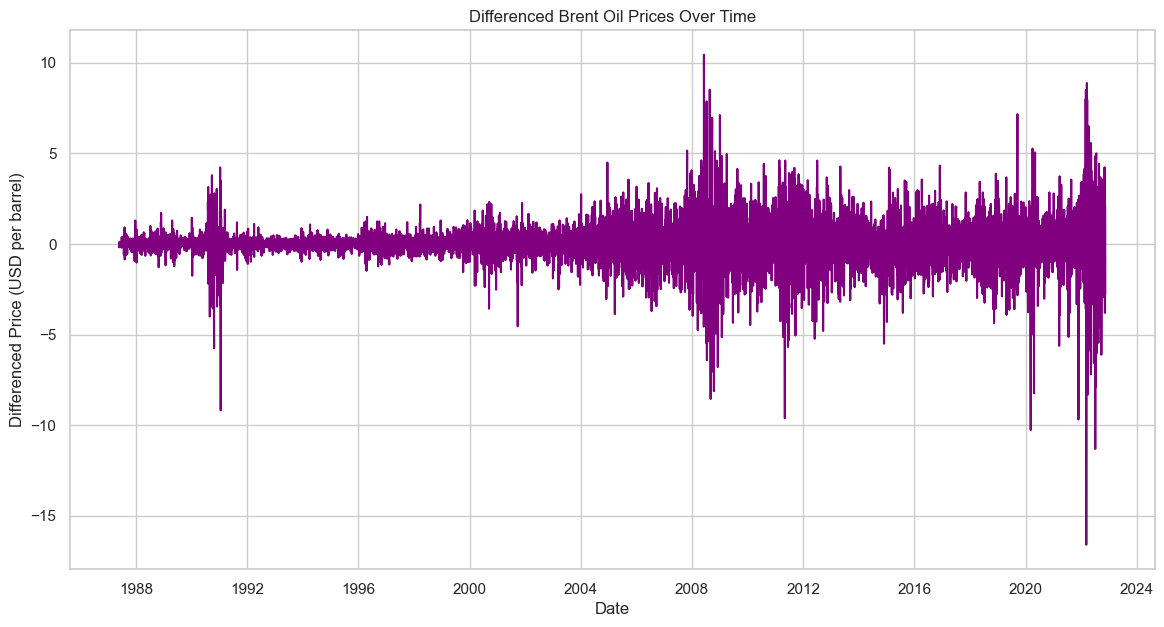

In [16]:
# Plot the differenced data
plt.figure(figsize=(14, 7))
plt.plot(data['Date'][1:], data['Price_diff'].dropna(), color='purple')
plt.title("Differenced Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Differenced Price (USD per barrel)")
plt.show()


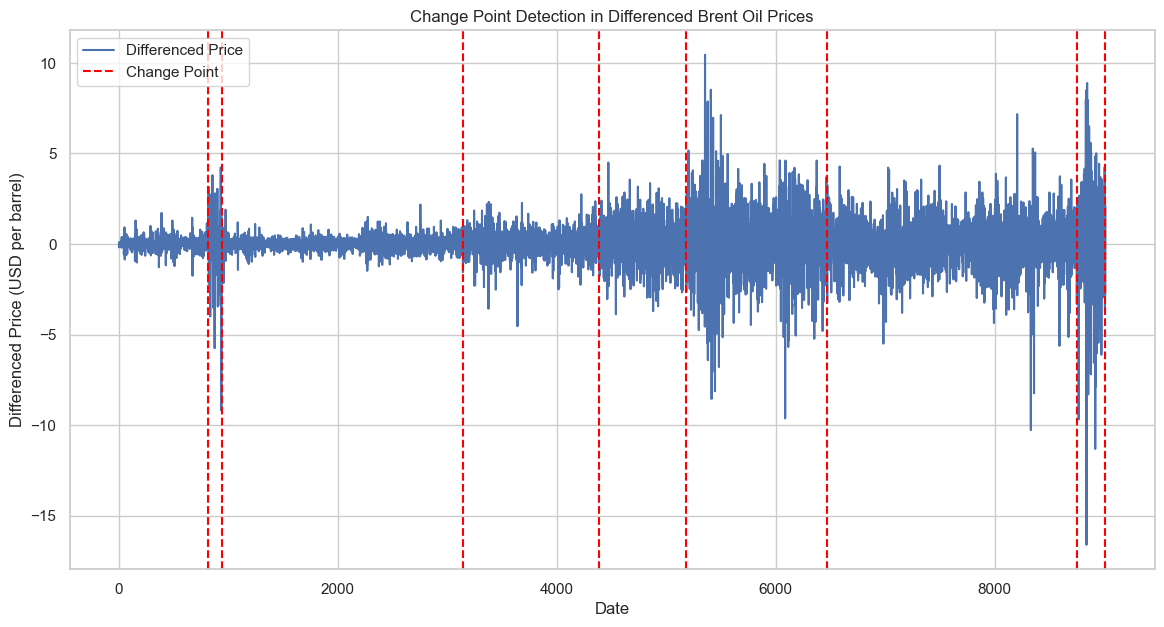

In [17]:
import ruptures as rpt

# Prepare data for change point detection (using differenced data)
series = data['Price_diff'].dropna().values

# Run PELT algorithm
algo = rpt.Pelt(model="rbf").fit(series)
change_points = algo.predict(pen=10)  # Adjust penalty as needed for sensitivity

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(data.index[1:], series, label="Differenced Price")
for cp in change_points:
    plt.axvline(data.index[cp], color='red', linestyle='--', label='Change Point' if cp == change_points[0] else "")
plt.legend()
plt.title("Change Point Detection in Differenced Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Differenced Price (USD per barrel)")
plt.show()


In [19]:
# Assuming we have a list of significant events and their dates
events = {
    '2014-06-01': 'OPEC Decision to Maintain Oil Production',
    '2020-03-01': 'COVID-19 Pandemic Onset and Lockdowns',
    '2022-02-24': 'Russia-Ukraine Conflict Escalation'
}

# Display detected change points with nearby events
change_dates = [data.index[cp] for cp in change_points]

for date in change_dates:
    # Ensure 'date' is a Timestamp object
    date = pd.Timestamp(date)
    print(f"Change Point Date: {date}")
    for event_date, event in events.items():
        event_date = pd.Timestamp(event_date)  # Ensure event_date is a Timestamp as well
        if abs((date - event_date).days) <= 30:  # Check if the event is within 30 days of change point
            print(f"  Associated Event: {event} on {event_date.date()}")


Change Point Date: 1970-01-01 00:00:00.000000815
Change Point Date: 1970-01-01 00:00:00.000000940
Change Point Date: 1970-01-01 00:00:00.000003140
Change Point Date: 1970-01-01 00:00:00.000004385
Change Point Date: 1970-01-01 00:00:00.000005180
Change Point Date: 1970-01-01 00:00:00.000006470
Change Point Date: 1970-01-01 00:00:00.000008750
Change Point Date: 1970-01-01 00:00:00.000009010


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14543.950
Date:                Fri, 01 Nov 2024   AIC                          29093.899
Time:                        11:57:39   BIC                          29115.218
Sample:                             0   HQIC                         29101.153
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.159     -2.152      0.031      -0.655      -0.031
ma.L1          0.3712      0.157      2.358      0.018       0.063       0.680
sigma2         1.4777      0.008    184.571      0.0

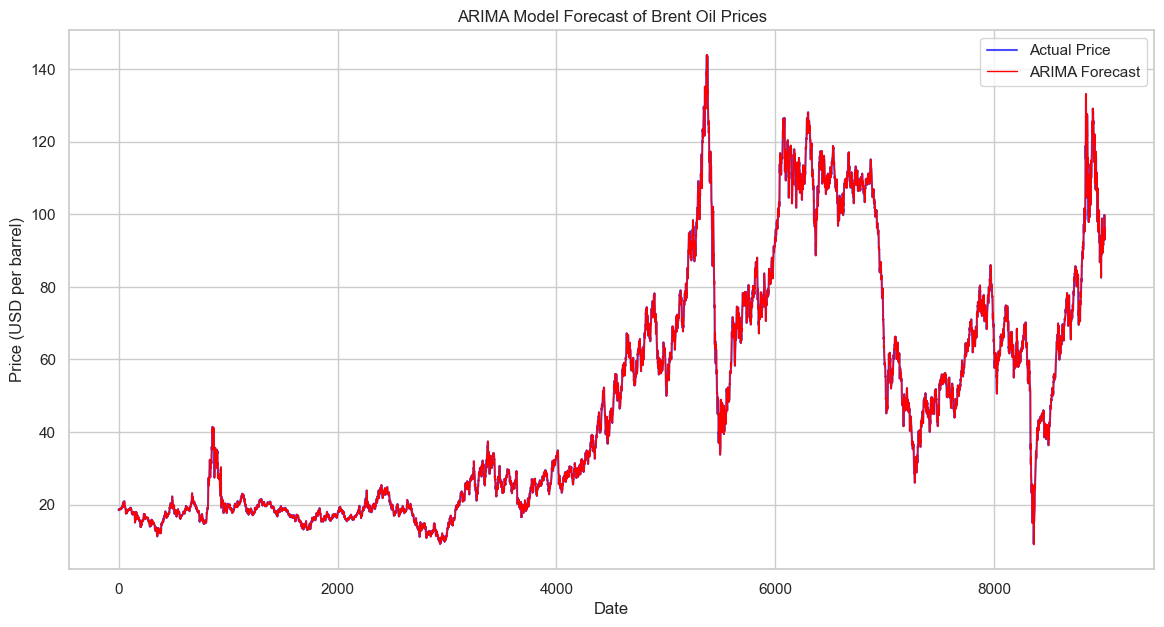

In [22]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA model on original (non-differenced) price data
model = ARIMA(data['Price'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# Generate forecast using the same index as data['Price']
forecast = model_fit.predict(start=data.index[1], end=data.index[-1], typ='levels')
forecast.index = data.index[1:]  # Align forecast index with actual data index

# Plot actual prices and forecasted prices
plt.figure(figsize=(14, 7))
plt.plot(data['Price'], label="Actual Price", color='blue', linewidth=1.5, alpha=0.7)
plt.plot(forecast, color='red', label="ARIMA Forecast", linewidth=1)
plt.legend()
plt.title("ARIMA Model Forecast of Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD per barrel)")
plt.show()
